# Stereo Vision
This assignment focuses on implementing and analyzing stereo vision algorithms. The goal is to compute disparity maps between left and right images using two methods:
1. **Block Matching** with Sum of Absolute Differences (SAD) and Sum of Squared Differences (SSD).
2. **Dynamic Programming** for optimal scanline alignment.
The results will be evaluated for different window sizes and compared for accuracy and performance.

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

left = cv2.imread('stereo_materials/l3.png', cv2.IMREAD_GRAYSCALE)
right = cv2.imread('stereo_materials/r3.png', cv2.IMREAD_GRAYSCALE)

window_sizes = [1, 5, 9]

## 1.1 Stereo Vision: Block Matching
**Objective**

Compute disparity maps by matching pixels between left (I_l) and right (I_r) images using:

* **SAD (Sum of Absolute Differences)**

* **SSD (Sum of Squared Differences)**

**Parameters:**

* Window sizes: `w = 1, 5, 9`

* Output: 6 disparity maps (3 window sizes × 2 cost functions).

**Approach**
1. For each pixel in `I_l`, compare with pixels in `I_r` along the same row.

2. Calculate SAD and SSD costs for each window size.

3. Assign the disparity with the minimum cost.

In [7]:
def compute_sad(left, right, window_size):
    height, width = left.shape
    disparity_map = np.zeros((height, width), np.uint8)
    offset = window_size // 2
    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            best_offset = 0
            min_sad = float('inf')
            for d in range(x):
                if x - d - offset < 0:
                    continue
                sad = np.sum(np.abs(
                    left[y-offset:y+offset+1, x-offset:x+offset+1] -
                    right[y-offset:y+offset+1, (x-d)-offset:(x-d)+offset+1]
                ))
                if sad < min_sad:
                    min_sad = sad
                    best_offset = d
            disparity_map[y, x] = int(np.clip(best_offset, 0, 255))
    return disparity_map

In [8]:
def compute_ssd(left, right, window_size):
    height, width = left.shape
    disparity_map = np.zeros((height, width), np.uint8)
    offset = window_size // 2
    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            best_offset = 0
            min_ssd = float('inf')
            for d in range(x):
                if x - d - offset < 0:
                    continue
                ssd = np.sum((
                    left[y-offset:y+offset+1, x-offset:x+offset+1] -
                    right[y-offset:y+offset+1, (x-d)-offset:(x-d)+offset+1]
                )**2)
                if ssd < min_ssd:
                    min_ssd = ssd
                    best_offset = d
            disparity_map[y, x] = np.clip(best_offset, 0, 255)
    return disparity_map

In [9]:
def plot_disparity_maps(left_img, right_img, window_sizes):
    """
    Compute and plot SAD/SSD disparity maps for different window sizes.
    """
    num_sizes = len(window_sizes)
    plt.figure(figsize=(15, 5 * num_sizes))  # Adjust figure size dynamically
    
    for idx, w in enumerate(window_sizes, 1):
        # Compute disparity maps
        sad_map = compute_sad(left_img, right_img, w)
        ssd_map = compute_ssd(left_img, right_img, w)
        
        # Plot SAD
        plt.subplot(num_sizes, 2, 2*idx - 1)
        plt.imshow(sad_map, cmap='gray')
        plt.colorbar(label='Disparity')
        plt.title(f'SAD Disparity (w={w})')
        plt.axis('off')
        
        # Plot SSD
        plt.subplot(num_sizes, 2, 2*idx)
        plt.imshow(ssd_map, cmap='gray')
        plt.colorbar(label='Disparity')
        plt.title(f'SSD Disparity (w={w})')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

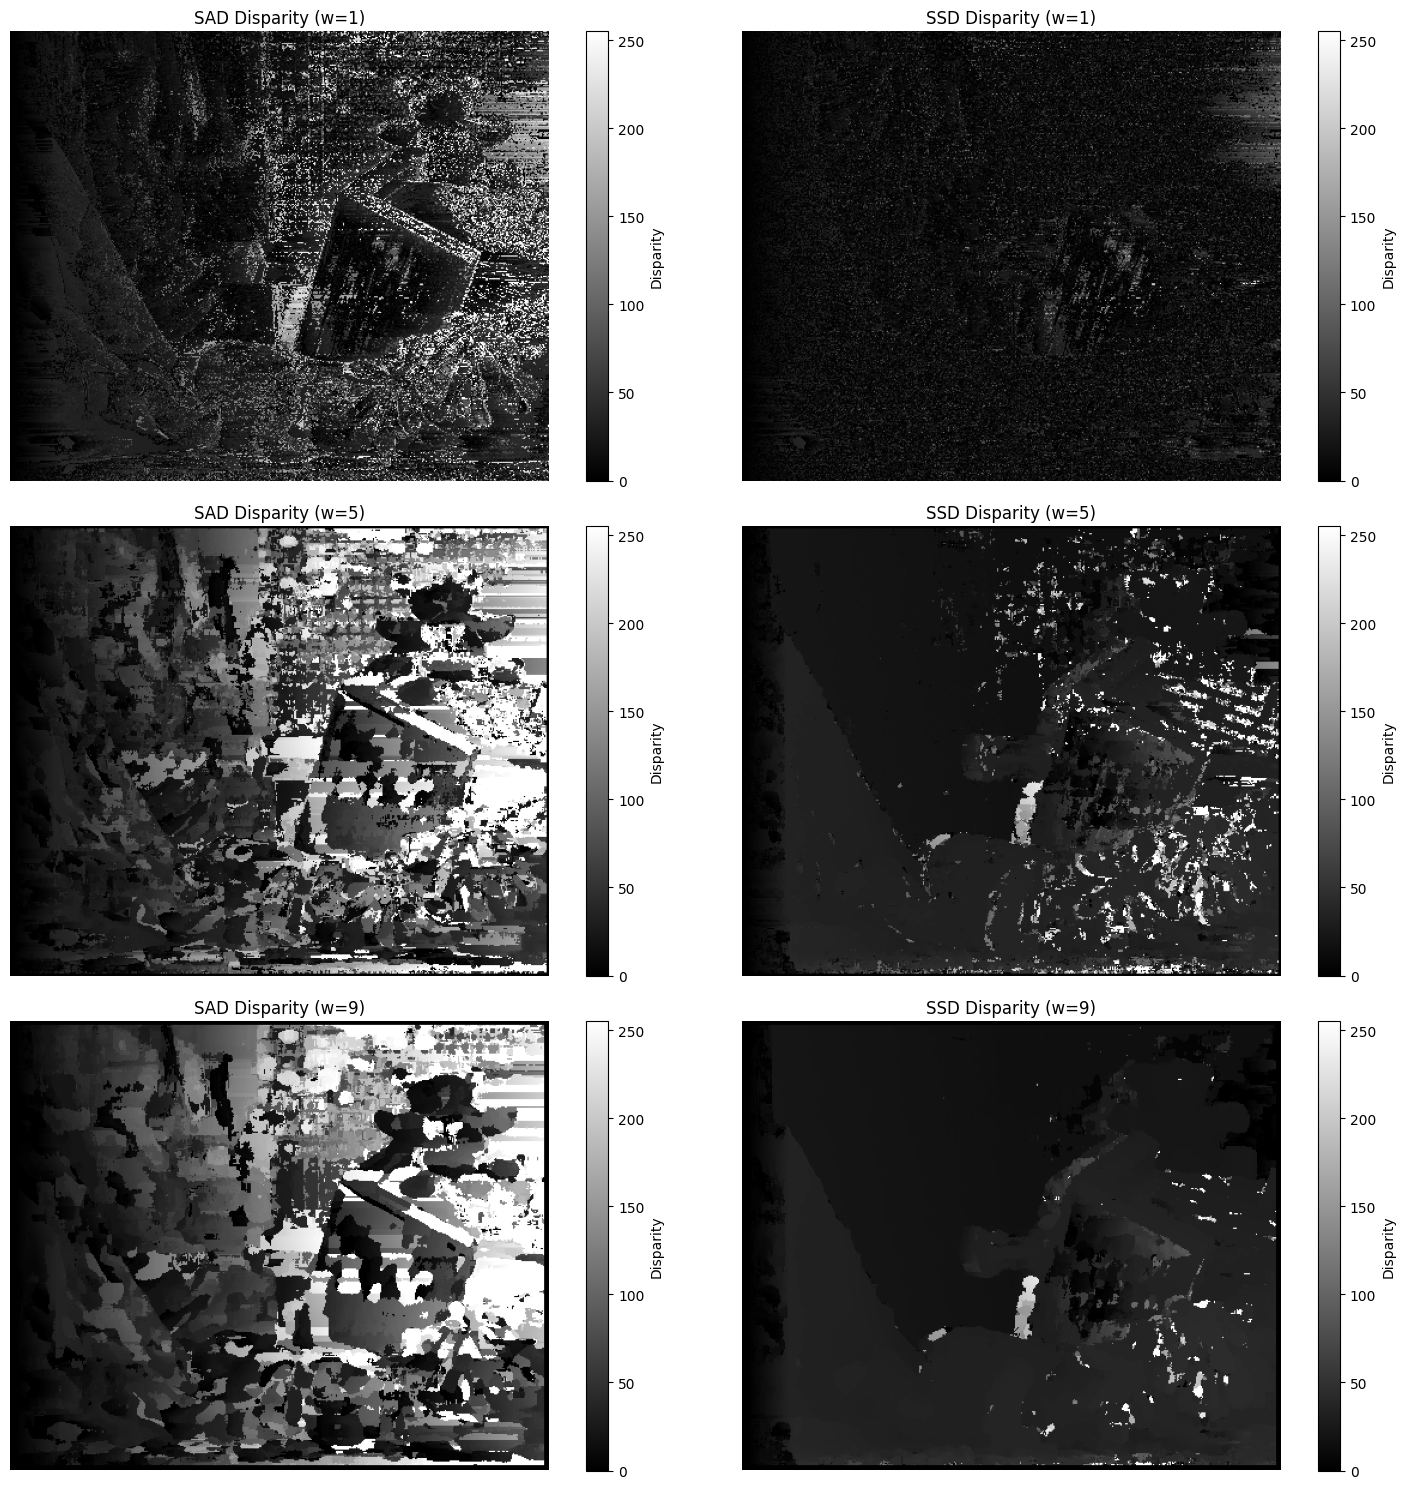

In [10]:
plot_disparity_maps(left, right, window_sizes)

## 1.1.2 Stereo Vision: Dynamic Programming
**Objective**
Compute disparity maps using dynamic programming to minimize the alignment cost of scanlines.

**Cost Definitions:**

* Matching cost: `d_ij = (I_l(i) - I_r(j))^2 / σ^2` (σ = 2)

* Occlusion cost: `c_0 = 1`

**Algorithm Steps**
1. Initialize cost matrix `D` with `D(1,1) = d_11`.

2. Fill `D(i,j)` using the recurrence

3. Backtrack from `D(N,N)` to `(1,1)` to determine disparities.

**Output:**

* Left and right disparity maps with occlusions marked as `0`.

In [11]:
def dynamic_programming(left_line, right_line, sigma=2, c0=1):
    n = len(left_line)
    D = np.zeros((n+1, n+1))
    
    # Initialize boundaries (occlusion costs)
    D[0, 1:] = np.arange(1, n+1) * c0  # Skip pixels in left image
    D[1:, 0] = np.arange(1, n+1) * c0  # Skip pixels in right image
    
    for i in range(1, n+1):
        for j in range(1, n+1):
            # Pixel matching cost (squared error normalized by sigma^2)
            cost = ((left_line[i-1] - right_line[j-1]) ** 2) / (sigma ** 2)
            D[i, j] = min(
                D[i-1, j-1] + cost,  # Match
                D[i-1, j] + c0,      # Skip in left
                D[i, j-1] + c0       # Skip in right
            )
    return D

In [13]:
def backtrack(D, left_line, right_line, sigma=2, c0=1):
    i, j = D.shape[0] - 1, D.shape[1] - 1
    path = []
    disparities = np.zeros(len(left_line))  # To store disparities
    
    while i > 0 and j > 0:
        current_cost = D[i, j]
        match_cost = ((left_line[i-1] - right_line[j-1]) ** 2) / (sigma ** 2)
        
        if current_cost == D[i-1, j-1] + match_cost:
            # Match: diagonal move
            disparities[i-1] = abs((i-1) - (j-1))  # Disparity = |i-j|
            path.append((i-1, j-1))
            i -= 1
            j -= 1
        elif current_cost == D[i-1, j] + c0:
            # Skip in left: vertical move
            disparities[i-1] = 0  # Occlusion in left
            i -= 1
        else:
            # Skip in right: horizontal move
            disparities[j-1] = 0  # Occlusion in right
            j -= 1
    
    return path[::-1], disparities  # Reverse path to start from (1,1)

In [14]:
def compute_disparity_map(left_img, right_img, sigma=2, c0=1):
    height, width = left_img.shape
    disparity_map = np.zeros((height, width))
    
    for y in range(height):
        left_line = left_img[y, :]
        right_line = right_img[y, :]
        D = dynamic_programming(left_line, right_line, sigma, c0)
        _, disparities = backtrack(D, left_line, right_line, sigma, c0)
        disparity_map[y, :] = disparities
    
    return disparity_map

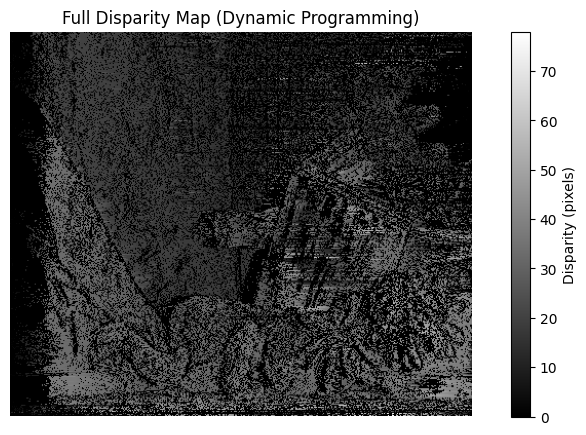

In [17]:
disparity_map = compute_disparity_map(left, right)

plt.figure(figsize=(10, 5))
plt.imshow(disparity_map, cmap='gray')
plt.colorbar(label='Disparity (pixels)')
plt.title('Full Disparity Map (Dynamic Programming)')
plt.axis('off')
plt.show()

## 1.2 Bonus: Scanline Alignment Visualization
Plot the alignment path for a single scanline:

* **Diagonal line:** Pixels matched.

* **Vertical line:** Pixel skipped in `I_l`.

* **Horizontal line:** Pixel skipped in `I_r`.

In [18]:
def plot_alignment(path, left_line, right_line):
    plt.figure(figsize=(10, 10))
    plt.plot(right_line, left_line, 'k-', alpha=0.3)  # Reference line
    
    x, y = 0, 0
    for i, j in path:
        if i == x + 1 and j == y + 1:
            plt.plot([y, j], [x, i], 'b-', linewidth=2)  # Diagonal (match)
        elif i == x + 1:
            plt.plot([y, y], [x, i], 'r-', linewidth=2)  # Vertical (skip left)
        else:
            plt.plot([y, j], [x, x], 'g-', linewidth=2)  # Horizontal (skip right)
        x, y = i, j
    
    plt.title("Scanline Alignment Path (Dynamic Programming)")
    plt.xlabel("Right Image Pixel Index")
    plt.ylabel("Left Image Pixel Index")
    plt.gca().invert_yaxis()  # Match assignment's convention
    plt.grid()
    plt.show()

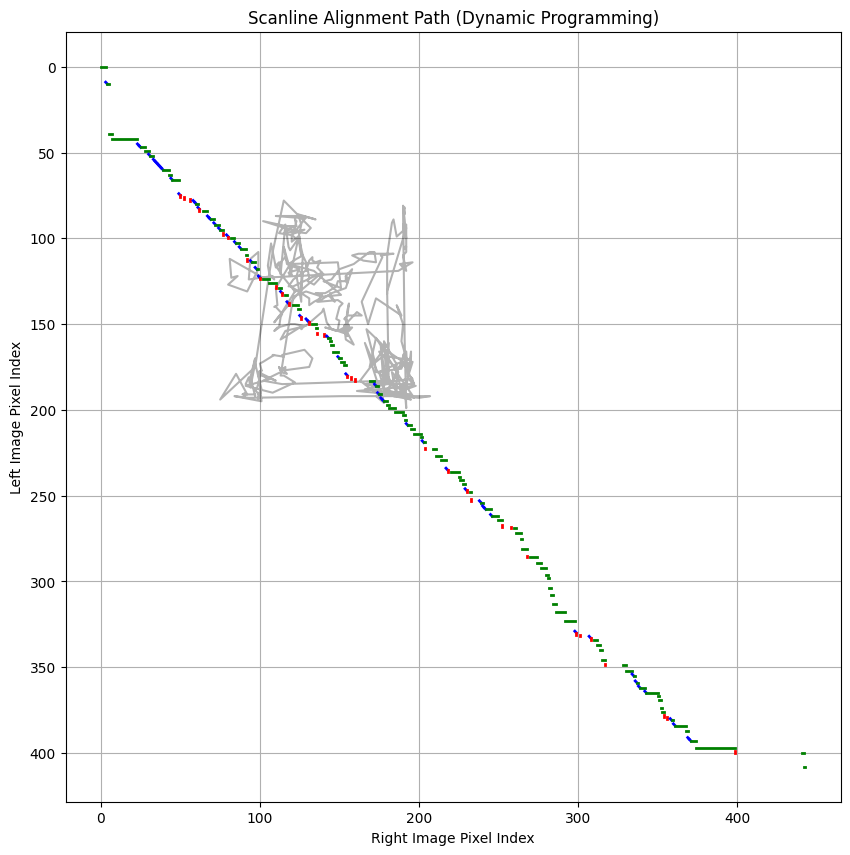

In [19]:
scanline_idx = 100  # Choose a representative row (e.g., middle)
left_line = left[scanline_idx, :]
right_line = right[scanline_idx, :]

D = dynamic_programming(left_line, right_line)
path, _ = backtrack(D, left_line, right_line)

plot_alignment(path, left_line, right_line)

## **Results and Analysis**
**Block Matching Observations**
* Larger window sizes (`w=5,9`) may smooth disparities but lose fine details.

* SSD penalizes large errors more than SAD.

**Dynamic Programming Observations**
* Handles occlusions better than block matching.

* Computational cost is higher due to `O(N^2)` matrix operations.

## Conclusion
This assignment demonstrated the trade-offs between block matching (efficiency) and dynamic programming (accuracy) for disparity estimation.